# 2A.i - Table de mortalité dans plusieurs containers

Pas de calcul d'espérence de vie, seulement différentes façons de lire les données d'une table de mortalité.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Récupération des données

Les données sont recensées sur [Data Publica](http://www.data-publica.com/) : [Table de mortalité](http://www.data-publica.com/opendata/7098--population-et-conditions-sociales-table-de-mortalite-de-1960-a-2010) qui les a récupéré depuis le site d'Eurostat via le listing suivant : [listing](http://epp.eurostat.ec.europa.eu/NavTree_prod/everybody/BulkDownloadListing?sort=1&dir=data). Pour faire court, le lien est le suivant : [demo_mlifetable.tsv.gz](http://epp.eurostat.ec.europa.eu/NavTree_prod/everybody/BulkDownloadListing?file=data/demo_mlifetable.tsv.gz). Le fichier est compressé au format [gzip](http://fr.wikipedia.org/wiki/Gzip). On le télécharge, on le décompresse.

In [3]:
url = "http://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/"
file = "demo_mlifetable.tsv.gz"
import pyensae
local = pyensae.download_data("demo_mlifetable.tsv.gz", url=url)
local = local[0]+".gz"
import gzip
with gzip.open(local, 'rb') as f: 
    file_content = f.read()
content = str(file_content, encoding="utf8")
with open("mortalite.txt", "w", encoding="utf8") as f:
    f.write(content)

Puis on le charge sous forme de dataframe :

In [4]:
import pandas
dff = pandas.read_csv("mortalite.txt", sep="\t", encoding="utf8")
dff.head()

,"indic_de,sex,age,geo\time",2017,2016,2015,2014,2013,2012,2011,2010,2009,...,1969,1968,1967,1966,1965,1964,1963,1962,1961,1960
0,"DEATHRATE,F,Y1,AL",0.00046,0.00043,0.00042 e,0.00042,0.00110,:,:,:,:,...,:,:,:,:,:,:,:,:,:,:
1,"DEATHRATE,F,Y1,AM",0.00052,0.00035,0.00035,:,:,:,:,:,0.00080,...,:,:,:,:,:,:,:,:,:,:
2,"DEATHRATE,F,Y1,AT",0.00017,0.00027,0.00017,0.00015,0.00016,0.00018,0.00018,0.00034,0.00042,...,:,:,:,:,:,:,:,:,:,:
3,"DEATHRATE,F,Y1,AZ",0.00081,:,0.00090,0.00092,0.00070,0.00132,:,0.00134,0.00111,...,:,:,:,:,:,:,:,:,:,:
4,"DEATHRATE,F,Y1,BE",0.00028,0.00025,0.00034,0.00035,0.00036,0.00025,0.00030,0.00021,0.00041,...,0.00141,0.00155,0.00132,0.00129,0.00153,0.00137,0.00170,0.00161,0.00168,0.00159


In [5]:
dff.shape

(99330, 59)

La première colonne contient une aggrégation de champs. On souhaite transformer cette table de telle sorte qu'on ait un nombre réduit de colonnes :

- indicateur
- genre
- age
- pays (ou ensemble de pays)
- annee
- valeur

L'âge est représenté sous forme de chaîne de caractères pour pouvoir écrire ``Y_LT1`` (moins d'un an), ``Y_GE85`` (plus de 85 ans). On change un peu le format pour pouvoir les trier par ordre croissant (en effet ``Y2`` est après ``Y10``). On sauve le tout dans un fichier pour ne pas avoir à recommencer ultérieurement. Malgré tout, le code ci-dessous est très lent pour la table complète qui contiendra au final près de 5 millions de lignes. On supprime les valeurs manquantes.

In [6]:
def format_age(s):
    if s.startswith("Y_") : 
        if s.startswith("Y_LT"): s = "Y00_LT" + s[4:]
        elif s.startswith("Y_GE"): s = "Y85_GE" + s[4:]
        else: raise FormatError(s)
    else:
        i = int(s.strip("Y"))
        return "Y%02d" % i
    
def format_value(s):
    if s.strip() == ":" : return -1
    else : return float(s.strip(" ebp"))
    
if False:  # sur les données complètes, c'est plutôt long, réduire la taille pour essayer
    dfsmall = dff.head(n = 1000) # on réduit la taille pour 
    df = dfsmall # implémenter la transformation
else:
    df = dff

print("étape 1", df.shape)
dfi = df.reset_index().set_index("indic_de,sex,age,geo\\time")
dfi = dfi.drop('index', axis=1)
dfs = dfi.stack()
dfs = pandas.DataFrame({"valeur": dfs } )

print("étape 2", dfs.shape)
dfs["valeur"] = dfs["valeur"].astype(str)
dfs["valeur"] = dfs["valeur"].apply( format_value )
dfs = dfs[ dfs.valeur >= 0 ].copy()
dfs = dfs.reset_index()
dfs.columns = ["index", "annee", "valeur"]

print("étape 3", dfs.shape)
dfs["age"] = dfs["index"].apply ( lambda i : format_age(i.split(",")[2]))
dfs["indicateur"] = dfs["index"].apply ( lambda i : i.split(",")[0])
dfs["genre"] = dfs["index"].apply ( lambda i : i.split(",")[1])
dfs["pays"] = dfs["index"].apply ( lambda i : i.split(",")[3])

print("étape 4")
dfy = dfs.drop('index', axis=1)
dfy.to_csv("mortalite_5column.txt", sep="\t", encoding="utf8", index=False)
dfy.head()

étape 1 (99330, 59)
étape 2 (5761140, 1)
étape 3 (3050745, 3)
étape 4


,annee,valeur,age,indicateur,genre,pays
0,2017,0.00046,Y01,DEATHRATE,F,AL
1,2016,0.00043,Y01,DEATHRATE,F,AL
2,2015,0.00042,Y01,DEATHRATE,F,AL
3,2014,0.00042,Y01,DEATHRATE,F,AL
4,2013,0.00110,Y01,DEATHRATE,F,AL


Graphe d'une coupe de la table de mortalité :

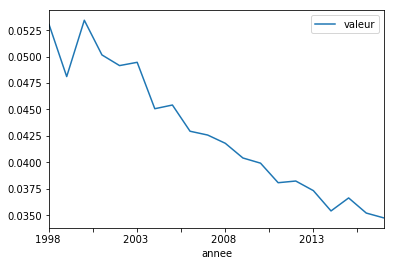

In [7]:
view = dfs [    (dfs.pays=="FR") &
                (dfs.age == "Y80") &
                (dfs.indicateur == "DEATHRATE") &
                (dfs.genre == "T")  ]
view = view.sort_values("annee")
view.plot(x="annee", y="valeur");

### SQLite

[SQLite](http://www.sqlite.org/) est un outils de gestion de base de données locales. Intégré à Python, il ne nécessite aucune installation. Il est très utile lorsque [Microsoft Excel](http://fr.wikipedia.org/wiki/Microsoft_Excel) ne peut pas contenir toutes les données qu'on souhaite consulter. Plus de deux millions de lignes dans le cas de cette table.

### version 1 : pandas to SQLite

On utilise pour la méthode [to_sql](http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.to_sql.html) et le module [sqlite3](https://docs.python.org/3.4/library/sqlite3.html). Ca prend un peu de temps (deux à trois minutes).

In [8]:
import sqlite3
con = sqlite3.connect("mortalite_sqlite3_y2.db3")
dfy.to_sql("table_mortalite",con)
con.close()  # il faut fermer la base qui sinon reste ouverte tant que le notebook
             # n'est pas fermé --> elle n'est pas modifiable pas d'autre que ce notebook

In [9]:
import os
[ _ for _ in os.listdir(".") if "sqlite3" in _ ]

['mortalite_sqlite3_y2.db3']

On utilise une requête SQL pour récupérer les données équivalent au code pandas cité ci-dessous :

In [10]:
con = sqlite3.connect("mortalite_sqlite3_y2.db3")
view = pandas.read_sql("""SELECT * FROM table_mortalite WHERE pays=="FR" 
            AND age == "Y80" 
            AND indicateur == "DEATHRATE"
            AND genre == "T"
            ORDER BY annee""", con)
con.close()

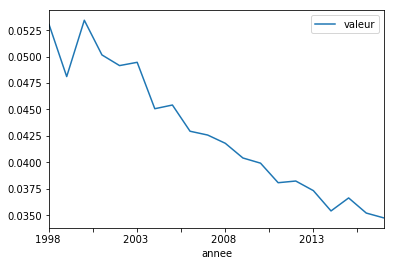

In [11]:
view.plot(x="annee", y="valeur");

### version 2 : pyensae

[import_flatfile_into_database](http://www.xavierdupre.fr/app/pyensae/helpsphinx/pyensae/sql/database_helper.html) est une fonction à utiliser lorsqu'on ne sait pas toujours quel est le séparateur de colonnes dans le fichier à importer. La fonction le devine pour vous ainsi que le type de chaque colonne (quand c'est possible). L'autre aspect intéressant est qu'elle affiche son état d'avancement. On repère plus rapidement que quelque chose se passe mal. Enfin, pour les gros fichiers, la fonction ne charge pas tout le fichier en mémoire. Cela permet de placer dans une base SQLite des milliards de lignes (cela peut prendre plus d'une heure). Ce n'est pas le cas ici, c'est juste à titre d'exemple. On stocke l'ensemble des données au format SQLite 3 de façon à pouvoir les consulter plus facilement.

In [12]:
from pyensae.sql import import_flatfile_into_database
import_flatfile_into_database("mortalite.db3", "mortalite_5column.txt")

  TextFile: opening file  mortalite_5column.txt
  TextFile.guess_columns: processing file  mortalite_5column.txt
  TextFile: opening file  mortalite_5column.txt
  TextFile.guess_columns: using  101  lines
  TextFile: closing file  mortalite_5column.txt
  TextFile.guess_columns: sep  '\t' nb cols 6  bestnb  101  more  {('\t', 5): 101, (' ', 1): 100}
  TextFile.guess_columns: header  True  columns  {0: ('annee', <class 'int'>), 1: ('valeur', <class 'float'>), 2: ('age', <class 'str'>), 3: ('indicateur', <class 'str'>), 4: ('genre', <class 'str'>), 5: ('pays', <class 'str'>)}
  compiling ^(?P<annee>([-]?[1-9][0-9]*?)|(0?))\t(?P<valeur>[-]?[0-9]*?([.][0-9]*?)?([eE][-]?[0-9]{0,4})?)\t(?P<age>.*)\t(?P<indicateur>.*)\t(?P<genre>.*)\t(?P<pays>.*)$
  TextFile.guess_columns: regex  ^(?P<annee>([-]?[1-9][0-9]*?)|(0?))\t(?P<valeur>[-]?[0-9]*?([.][0-9]*?)?([eE][-]?[0-9]{0,4})?)\t(?P<age>.*)\t(?P<indicateur>.*)\t(?P<genre>.*)\t(?P<pays>.*)$
  TextFile.guess_columns: header  True  columns  {0: ('anne

'mortalite_5column'

Ensuite, on peut facilement consulter les données avec le logiciel (sous Windows) [SQLiteSpy](http://www.yunqa.de/delphi/doku.php/products/sqlitespy/index) ou l'extension [sqlite-manager](https://addons.mozilla.org/fr/firefox/addon/sqlite-manager/) pour Firefox sous toutes les plates-formes. Pour cet exercice, on exécute :

In [13]:
sql = """SELECT * FROM mortalite_5column WHERE pays=="FR" 
            AND age == "Y80" 
            AND indicateur == "DEATHRATE"
            AND genre == "T"
            ORDER BY annee"""

from pyensae.sql import Database
db = Database("mortalite.db3", LOG = lambda *l : None)
db.connect()
view = db.to_df(sql)
view

,annee,valeur,age,indicateur,genre,pays
0,1998,0.05303,Y80,DEATHRATE,T,FR
1,1999,0.04811,Y80,DEATHRATE,T,FR
2,2000,0.05344,Y80,DEATHRATE,T,FR
3,2001,0.05016,Y80,DEATHRATE,T,FR
4,2002,0.04915,Y80,DEATHRATE,T,FR
5,2003,0.04946,Y80,DEATHRATE,T,FR
6,2004,0.04507,Y80,DEATHRATE,T,FR
7,2005,0.04542,Y80,DEATHRATE,T,FR
8,2006,0.04294,Y80,DEATHRATE,T,FR
9,2007,0.04258,Y80,DEATHRATE,T,FR


Visuellement, cela donne :

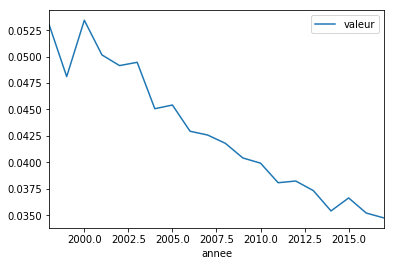

In [14]:
view.plot(x="annee", y="valeur")

## Cube de données

On utilise l'expression *cube de données* pour désigner à tableaux à plusieurs dimensions. On le représente souvent par une liste ``coordonnées, valeurs``. C'est souvent beaucoup de données et pas forcément de moyen pratique de les manipuler. On utilise le module [xarray](http://xarray.pydata.org/en/stable/). [pandas](https://pandas.pydata.org/pandas-docs/stable/) propose automatiquement d'exporter les données vers ce module avec [to_xarray](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_xarray.html#pandas-dataframe-to-xarray).

In [15]:
import pandas 
df = pandas.read_csv("mortalite_5column.txt", sep="\t", encoding="utf8")
df.shape

(3050745, 6)

In [16]:
df.head(n=2)

,annee,valeur,age,indicateur,genre,pays
0,2017,0.00046,Y01,DEATHRATE,F,AL
1,2016,0.00043,Y01,DEATHRATE,F,AL


On passe du côté *index* toutes les colonnes excepté *valeur*.

In [17]:
cols = [_ for _ in df.columns if _ != "valeur"]
cols

['annee', 'age', 'indicateur', 'genre', 'pays']

On laisse tomber les valeurs manquantes.

In [18]:
df.shape

(3050745, 6)

In [19]:
df = df.dropna()
df.shape

(2979765, 6)

On vérifie qu'il n'y a pas de doublons car la conversion en *cube* ne fonctionne pas dans ce cas puisque deux valeurs seraient indexées avec les mêmes coordonnées.

In [20]:
dup = df.groupby(cols).count().sort_values("valeur", ascending=False)
dup = dup[dup.valeur > 1]
dup.head(n=2)

,,,,,valeur
annee,age,indicateur,genre,pays,


In [21]:
dup.shape

(0, 1)

In [22]:
dfi = df.set_index(cols, verify_integrity=True)
dfi.head(n=2)

,,,,,valeur
annee,age,indicateur,genre,pays,
2017,Y01,DEATHRATE,F,AL,0.00046
2016,Y01,DEATHRATE,F,AL,0.00043


In [23]:
type(dfi.index)

pandas.core.indexes.multi.MultiIndex

On vérifie que [xarray](http://xarray.pydata.org/en/stable/) est installé.

In [24]:
import xarray

Et on convertit en cube.

In [25]:
cube = xarray.Dataset.from_dataframe(dfi) # ou dfi.to_xarray()

In [26]:
cube

<xarray.Dataset>
Dimensions:     (age: 84, annee: 58, genre: 3, indicateur: 7, pays: 55)
Coordinates:
  * annee       (annee) int64 1960 1961 1962 1963 1964 ... 2014 2015 2016 2017
  * age         (age) object 'Y01' 'Y02' 'Y03' 'Y04' ... 'Y81' 'Y82' 'Y83' 'Y84'
  * indicateur  (indicateur) object 'DEATHRATE' 'LIFEXP' ... 'TOTPYLIVED'
  * genre       (genre) object 'F' 'M' 'T'
  * pays        (pays) object 'AL' 'AM' 'AT' 'AZ' 'BE' ... 'TR' 'UA' 'UK' 'XK'
Data variables:
    valeur      (annee, age, indicateur, genre, pays) float64 nan nan ... nan

In [27]:
back_to_pandas = cube.to_dataframe().reset_index(drop=True)
back_to_pandas.head(n=2)

,valeur
0,NaN
1,NaN


Et on prend le maximum par *indicateur* et *genre*.

In [28]:
cube.max(dim=["age", "annee", "pays"]).to_dataframe().reset_index().pivot("indicateur", "genre", "valeur")

genre,F,M,T
indicateur,,,
DEATHRATE,9.978600e-01,1.130040e+00,1.040580e+00
LIFEXP,8.580000e+01,8.310000e+01,8.460000e+01
PROBDEATH,6.657100e-01,7.220600e-01,6.844600e-01
PROBSURV,1.000000e+00,1.000000e+00,1.000000e+00
PYLIVED,1.000000e+05,1.000000e+05,1.000000e+05
SURVIVORS,1.000000e+05,1.000000e+05,1.000000e+05
TOTPYLIVED,8.583361e+06,8.307177e+06,8.456903e+06


In [29]:
cube.to_dataframe().groupby('indicateur').max()

,valeur
indicateur,
DEATHRATE,1.130040e+00
LIFEXP,8.580000e+01
PROBDEATH,7.220600e-01
PROBSURV,1.000000e+00
PYLIVED,1.000000e+05
SURVIVORS,1.000000e+05
TOTPYLIVED,8.583361e+06


In [30]:
try:
    cube.groupby("indicateur").max().to_dataframe().head()
except ValueError as e:
    # It used to be working in 0.12 but not in 0.13...
    print(e)

Dataset does not contain the dimensions: ['indicateur']


In [31]:
cube["valeur"].sel(indicateur="LIFEXP", genre="F", annee=slice(1980, 1985)).to_dataframe().head()

indicateur genre  valeur
annee age pays                         
1980  Y01 AL       LIFEXP     F     NaN
          AM       LIFEXP     F     NaN
          AT       LIFEXP     F    76.1
          AZ       LIFEXP     F     NaN
          BE       LIFEXP     F    76.5

In [32]:
cube["valeur"].max(dim=["age"]).to_dataframe().head()

c:\python372_x64\lib\site-packages\xarray\core\nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


valeur
annee indicateur genre pays         
1960  DEATHRATE  F     AL        NaN
                       AM        NaN
                       AT        NaN
                       AZ        NaN
                       BE    0.15967

On ajoute une colonne avec un ratio où on divise par le maximum sur une classe d'âge.

In [33]:
cube["max_valeur"] = cube["valeur"] / cube["valeur"].max(dim=["age"])

In [34]:
cube.to_dataframe().head()

valeur  max_valeur
age annee genre indicateur pays                     
Y01 1960  F     DEATHRATE  AL        NaN         NaN
                           AM        NaN         NaN
                           AT        NaN         NaN
                           AZ        NaN         NaN
                           BE    0.00159    0.009958